## ML Algorithms, Part 7, Random Forests

Many trees make a forest, many random trees, make a Random Forest. Leaving the lame pun behind, Random Forests are nothing more than a collection of Decision Trees that aim to create better models by reducing varience/overfitting. If we created the same Decision Tree a hundred times we wouldn't get any improvement in terms of predictive power; we need more diversity. There are a few ways to achieve said diversity: train a tree multiple times with a different ordering of splits, train tree models with different parameters, or combine these and also randomly drop some variables and/or training examples, which is what the Random Forest algorithm does.

#### Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier # This is an ensemble model
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_breast_cancer # we will use the same dataset
from sklearn.model_selection import train_test_split

In [2]:
br_cancer = load_breast_cancer()

X = br_cancer.data
Y = br_cancer.target

df = pd.DataFrame(np.concatenate([X, Y.reshape((-1,1))],axis=1), 
                  columns=np.concatenate([br_cancer.feature_names,["Class"]]))

In [3]:
# Again we only pick 5 variables
x_train, x_test, y_train, y_test = train_test_split(X[:,0:30:6], Y)

In [4]:
# use 3 cores for faster performance
# create 200 trees
rfc = RandomForestClassifier(200, n_jobs=3)

rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=3,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [5]:
print("Training accuracy: {:.2f}%".format(rfc.score(x_train, y_train)*100))
print("Testing accuracy: {:.2f}%".format(rfc.score(x_test, y_test)*100))

Training accuracy: 100.00%
Testing accuracy: 95.80%


Quite an improvement in accuracy. We will run the model multiple times to compare results. Do note that 200 times (times 200 trees each) is a lot and it might take a while. Feel free to reduce both number of trees and number of iterations, or increase `n_jobs`. Then, we will try this again, but with the whole dataset.

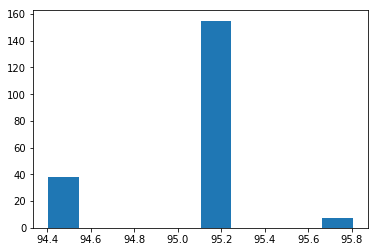

In [6]:
test_accs  = []
for _ in range(200):
    rfc_val =  RandomForestClassifier(200, n_jobs=3)
    rfc_val.fit(x_train, y_train)
    test_accs.append(rfc_val.score(x_test, y_test)*100)
    
plt.hist(test_accs);

It seems there is some difference compared to the Decision Tree, the distribution looks very similar, but it was moved upward by ~3%, which is a good improvement, and variance changed (our results are roughly within a ±1%). However, I've got a feeling that using all of the predictors will help create a better model.

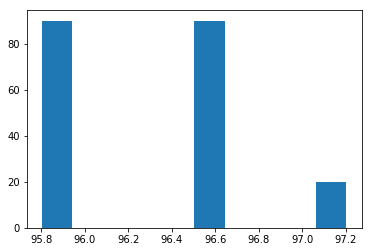

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y) # use all variables

test_accs  = []
for _ in range(200):
    rfc_val =  RandomForestClassifier(200, n_jobs=3)
    rfc_val.fit(x_train, y_train)
    test_accs.append(rfc_val.score(x_test, y_test)*100)
    
plt.hist(test_accs);

And indeed this model seems better! The median is at ~96.5% and the interval is still ±1%, but now many more of the models are in the upper range rather than the lower range. Not only the worst Random Forest model will be better than a Decision Tree model, but *most* of our Random Forests will be better than the *best* Decision Tree!

But there is still room for improvement. We can experiment a lot with the model parameters, and compare how they fare. We will search with a predefined grid of parameters. *This will take some time*, it took ~5 minutes for our machine.

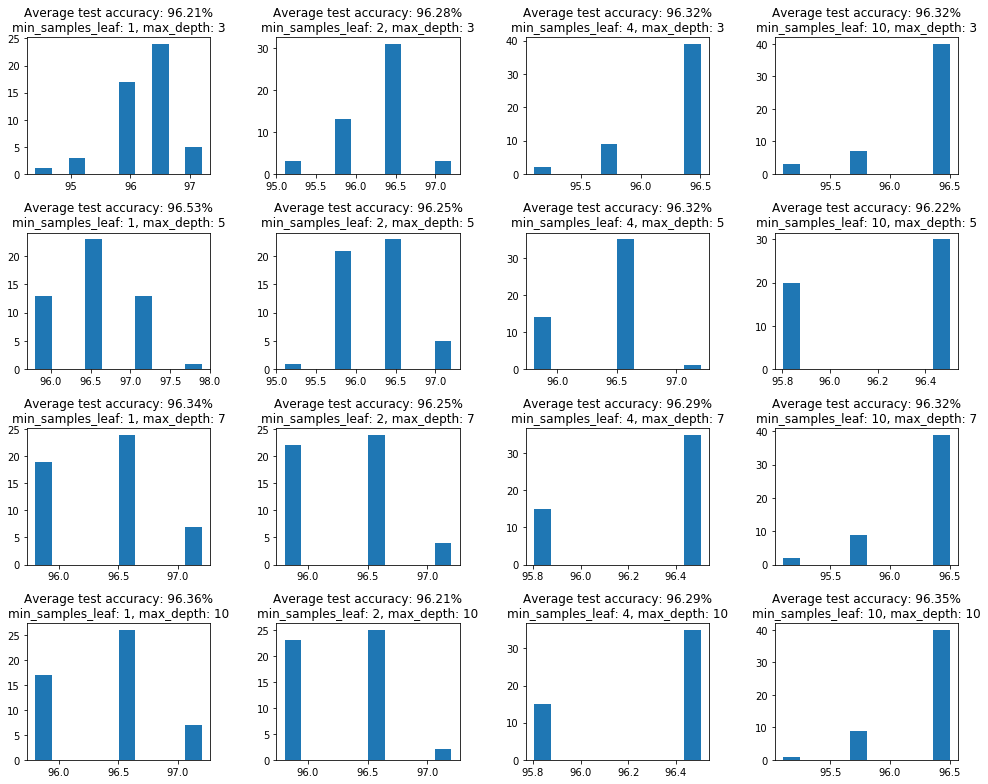

In [8]:
fig, axes = plt.subplots(4,4, figsize=(14,11))

max_depths = [3,5,7,10]
min_samples_leafs = [1,2,4,10]

# every row will have the same max_depth
# every column will have the same min_samples_leaf
for row, depth in zip(axes, max_depths):
    for ax, min_leafs in zip(row, min_samples_leafs):
        
        test_accs  = []
        # just 50 iterations and ensemble 100 trees, since we draw 16x the histograms
        for _ in range(50):
            rfc_val =  RandomForestClassifier(100, n_jobs=4, max_depth=depth, min_samples_leaf=min_leafs)
            rfc_val.fit(x_train, y_train)
            test_accs.append(rfc_val.score(x_test, y_test)*100)
            
        ax.hist(test_accs)
        ax.set_title("Average test accuracy: {:.2f}%\nmin_samples_leaf: {}, max_depth: {}".format(np.mean(test_accs),
                                                                                        min_leafs, depth))
        
plt.tight_layout()

There is not much variation, and that is a good thing. We can expect that on unseen data our model will perform equally well. As is always the case with Machine Learning, tuning the parameters and getting as much data as possible are both import steps. We will see that when using Neural Networks in a future article.